#### [1]

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import missingno as msn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor


In [2]:
data = pd.read_csv("machine.data_update.csv")
data
data.columns 

Index(['VendorName', 'ModelName', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN',
       'CHMAX', 'PRP', 'ERP'],
      dtype='object')

In [3]:
print(data.info())
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB
None
Index(['VendorName', 'ModelName', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN',
       'CHMAX', 'PRP', 'ERP'],
      dtype='object')


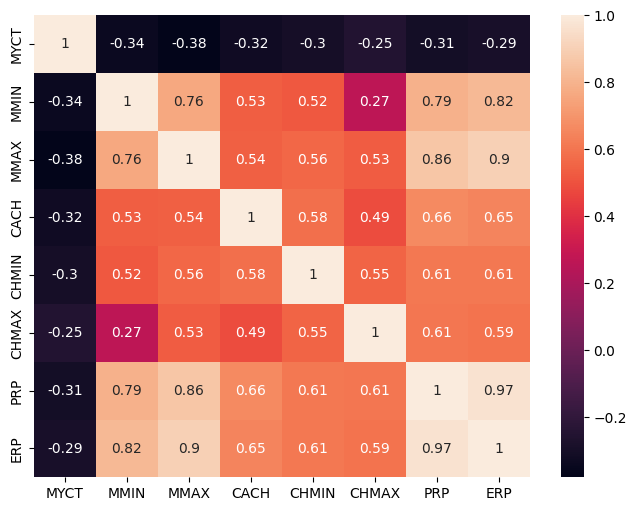

In [4]:
n_data = data.select_dtypes(include=[np.number]) #숫자형 변수만 선택하기

plt.figure(figsize=(8, 6)) # 상관행렬
sns.heatmap(n_data.corr(), annot=True)
plt.show()


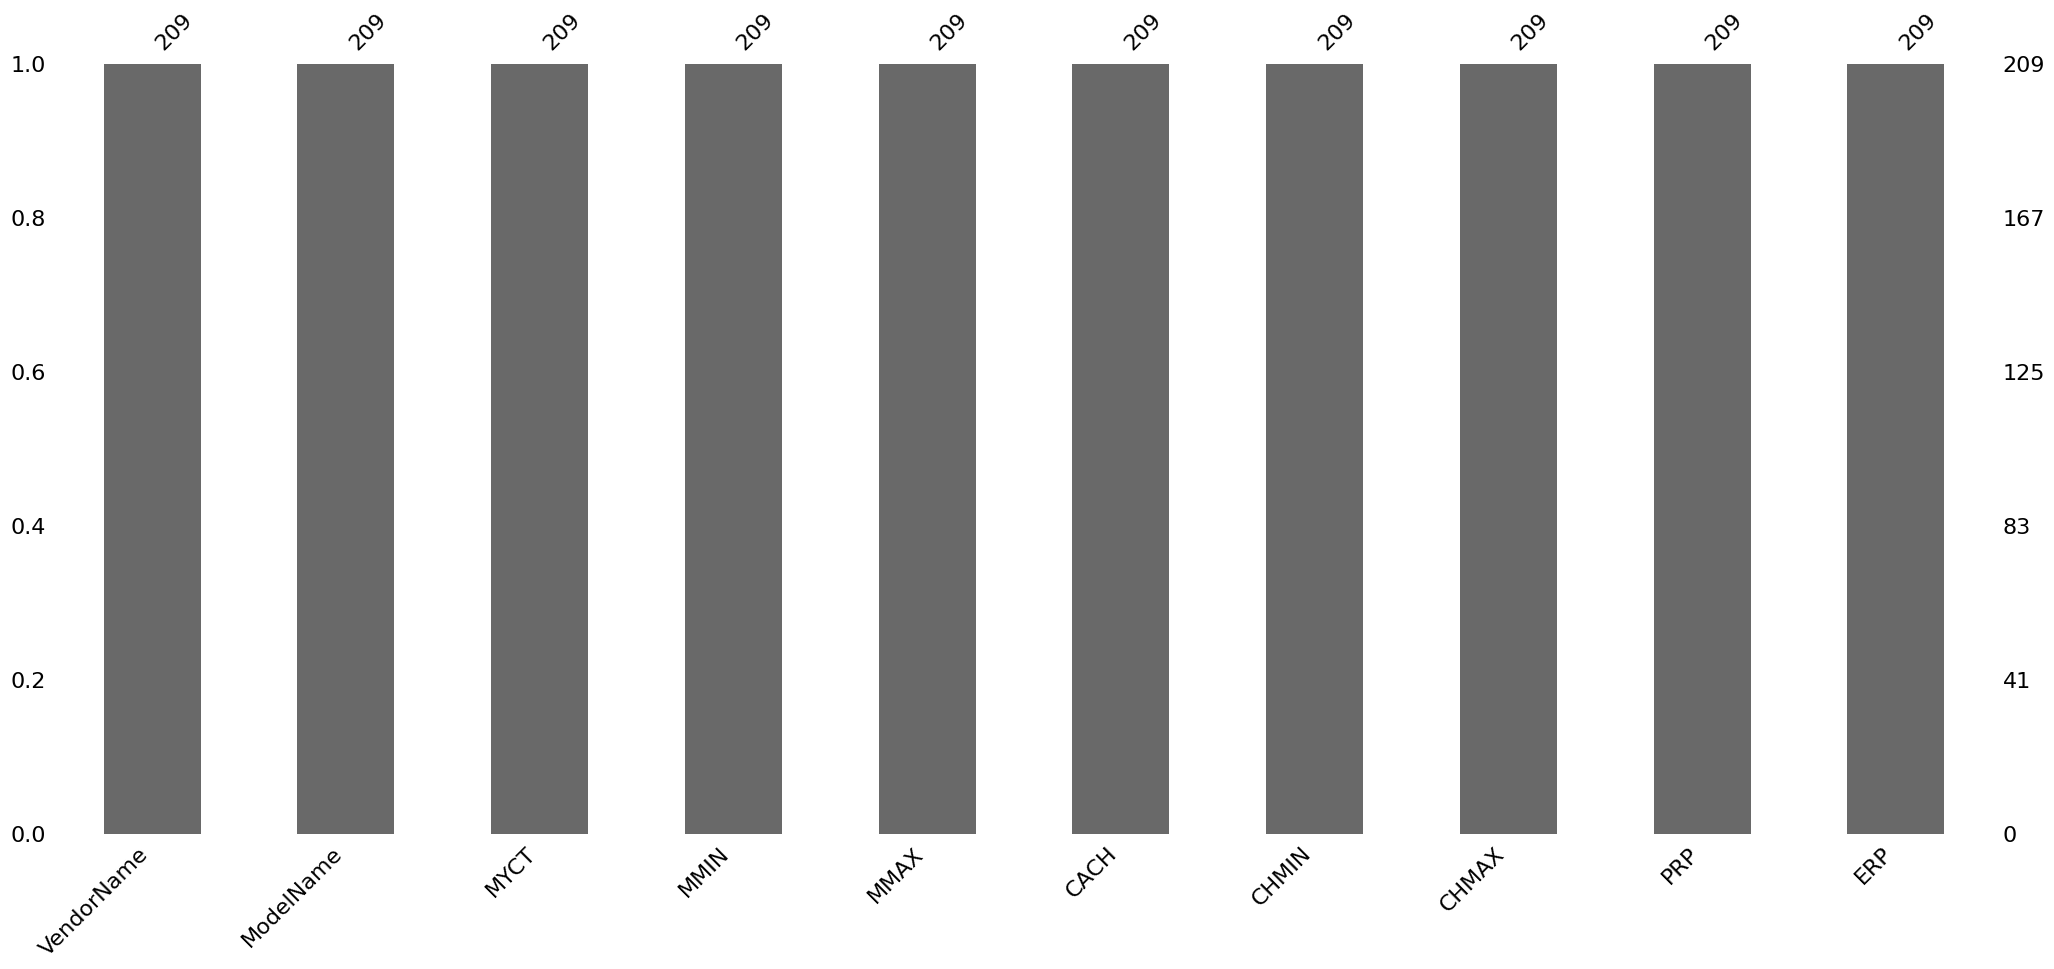

In [5]:
msn.bar(data)
data.dropna(inplace = True)
plt.show()

X = data.drop(columns=['VendorName', 'ModelName', 'PRP'])
y = data['PRP']

In [6]:
n_features = X.columns
n_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', n_transformer, n_features)])

In [7]:
X.shape,  y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
models = [('lr', LinearRegression()), ('sgd', SGDRegressor())] # 개별 모델 정의
ensemble = VotingRegressor(estimators=models) # 앙상블 모델 정의

In [9]:
# 모델 파이프라인 
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                 ('ensemble', ensemble)])

# 하이퍼 파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
    'ensemble__sgd__max_iter': [1000, 2000, 3000]
}


In [10]:
param_grid = {
    'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
    'ensemble__sgd__max_iter': [1000, 2000, 3000]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'ERP'], dtype='object'))])),
                                       ('ensemble',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('sgd',
                                                                     SGDRegressor())]))]),
             param_grid={'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
                         'ensemble__sgd__max_iter': [1000, 2000, 3000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [11]:
# 최적 파라미터 출력
print(f"Best parameters found: {grid_search.best_params_}")

# 최적 모델로 예측
best_model = grid_search.best_estimator_

# 테스트 데이터에 대한 예측
y_pred = best_model.predict(X_test)
y_pred.shape
y_pred[:10]

Best parameters found: {'ensemble__sgd__alpha': 0.0001, 'ensemble__sgd__max_iter': 3000}


array([ 121.45772694,   26.40974159,   27.31045496,  966.34634773,
         26.60617461,  274.3667556 ,   44.91436661,   20.80715805,
       1280.56290603,  242.80713507])

MSE: 2072.5654894137488, MAE: 30.089993752171235, R^2: 0.9592871026165152


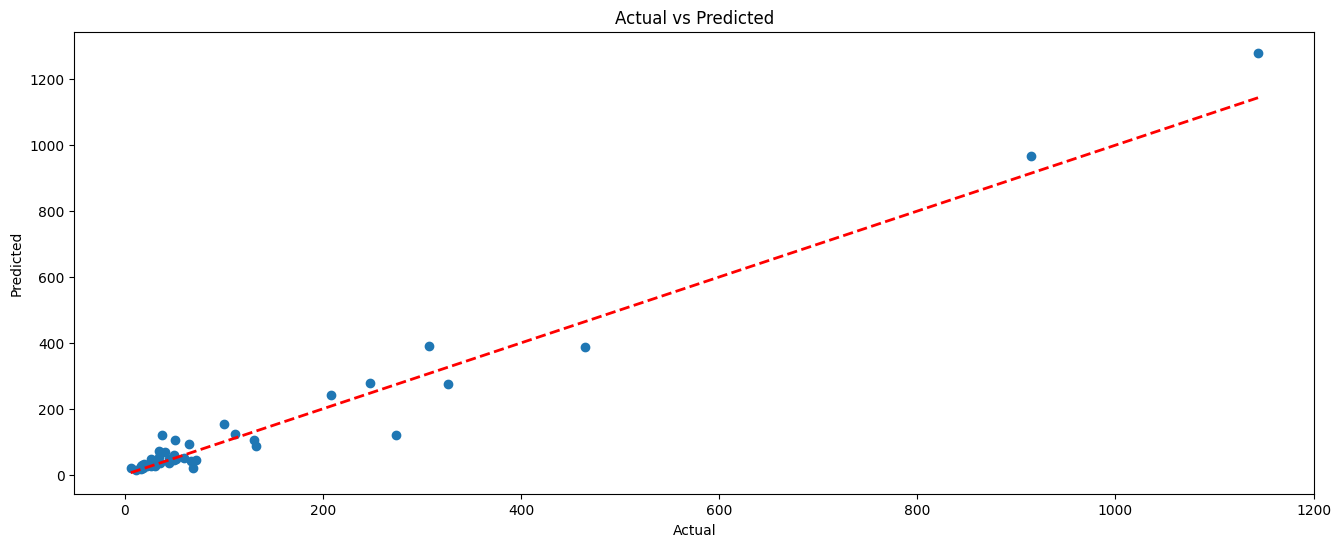

In [12]:
# 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")

# 시각화
plt.figure(figsize=(16, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [13]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()
print(f'Cross-Validated MSE: {cv_mse}')

Cross-Validated MSE: 2946.9147891212197


In [14]:
train_pred = best_model.predict(X_train) # 훈련데이터 예측
train_mse = mean_squared_error(y_train, train_pred)
print(f'Training MSE: {train_mse}')

Training MSE: 1542.6758644406348


In [15]:
results = pd.DataFrame({
    'Data': ['Train', 'Test'],
    'MSE': [train_mse, mse],
    'MAE': [mean_absolute_error(y_train, train_pred), mae],
    'R^2': [r2_score(y_train, train_pred), r2]
})

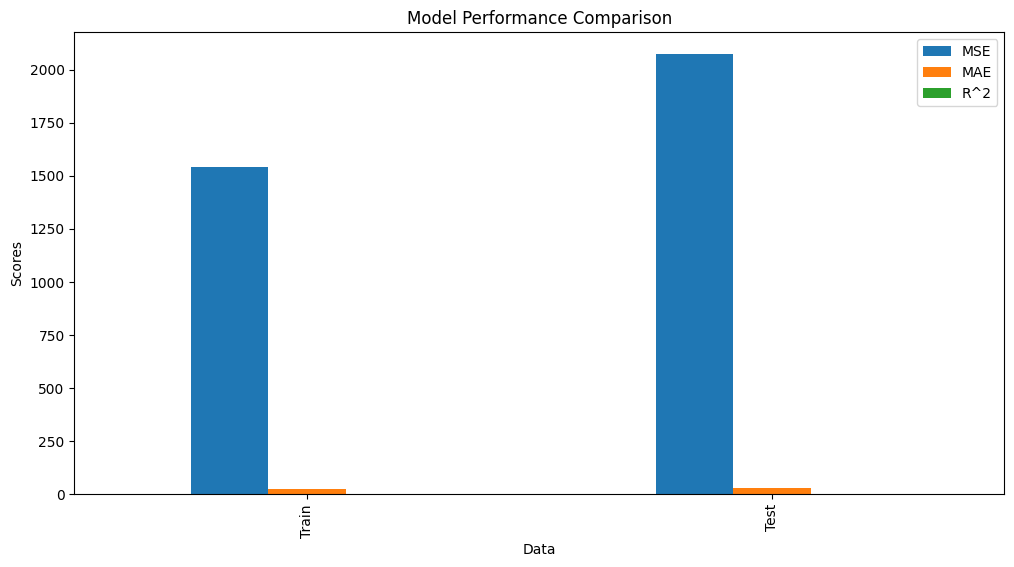

In [16]:
results.set_index('Data', inplace=True) # 성능비교 시각화
results.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Scores')
plt.show()

#### [2]

In [17]:
train_pred = best_model.predict(X_train) # 학습데이터 예측

test_pred = best_model.predict(X_test) # 테스트 데이터 예측

# 학습 데이터 
train_mse = mean_squared_error(y_train, train_pred) # MSE 
train_mae = mean_absolute_error(y_train, train_pred) # MAE
train_r2 = r2_score(y_train, train_pred) # R^2

#테스트 데이터 
test_mse = mean_squared_error(y_test, test_pred)# MSE 
test_mae = mean_absolute_error(y_test, test_pred) # MAE
test_r2 = r2_score(y_test, test_pred)# R^2

# 결과 출력
print(f"Training Data - MSE: {train_mse}, MAE: {train_mae}, R^2: {train_r2}")
print(f"Testing Data - MSE: {test_mse}, MAE: {test_mae}, R^2: {test_r2}")

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5) # 5폴드 교차 검증 수행
cv_mse = -cv_scores.mean() # 교차 검증 평균 MSE 계산

print(f"Cross-Validated Mean Squared Error: {cv_mse}") 

Training Data - MSE: 1542.6758644406348, MAE: 23.190999719078956, R^2: 0.9197544905565772
Testing Data - MSE: 2072.5654894137488, MAE: 30.089993752171235, R^2: 0.9592871026165152
Cross-Validated Mean Squared Error: -0.8398793160065434


#### [3]

In [ ]:
param_grid = {
'rf__n_estimators': [100, 200, 300],
'rf__max_depth': [5, 10, 15],
'rf__min_samples_split': [2, 5, 10],
'rf__min_samples_leaf': [1, 2, 4],
'rf__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
cv_mse = -np.mean(cv_scores)

print(f"Training Data - MSE: {train_mse}, MAE: {train_mae}, R^2: {train_r2}")
print(f"Testing Data - MSE: {test_mse}, MAE: {test_mae}, R^2: {test_r2}")
print(f"Cross-Validated Mean Squared Error: {cv_mse}")


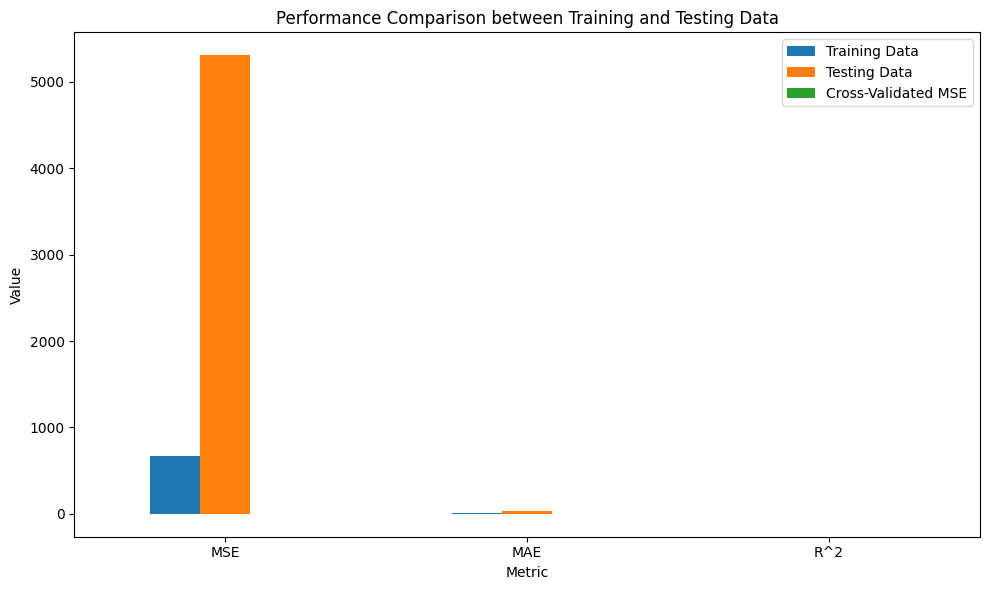

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# 성능 지표를 데이터프레임에 저장
performance_metrics = {
    'Metric': ['MSE', 'MAE', 'R^2'],
    'Training Data': [train_mse, train_mae, train_r2],
    'Testing Data': [test_mse, test_mae, test_r2],
    'Cross-Validated MSE': [cv_mse, cv_mse, cv_mse]  # 교차 검증의 경우 동일하게 표시됨
}

df_performance = pd.DataFrame(performance_metrics)

# 바 차트로 시각화
df_performance.plot(x='Metric', kind='bar', figsize=(10, 6))
plt.ylabel('Value')
plt.title('Performance Comparison between Training and Testing Data')
plt.xticks(rotation=0)  # x축 라벨 회전 제거
plt.tight_layout()
plt.show()
